# Lesson 03

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

import itertools

import warnings

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
pjme_url = 'https://d2xzmw6cctk25h.cloudfront.net/asset/1618427/attachment/974ec34a7bf6ac7349985c09292a6e95.csv'

In [4]:
df = pd.read_csv(pjme_url, index_col=['Date'], parse_dates=['Date', 'Time'])

In [5]:
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,2020-01-26 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,2020-01-26 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,2020-01-26 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,2020-01-26 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,2020-01-26 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [6]:
df_m = df.resample('M').mean()

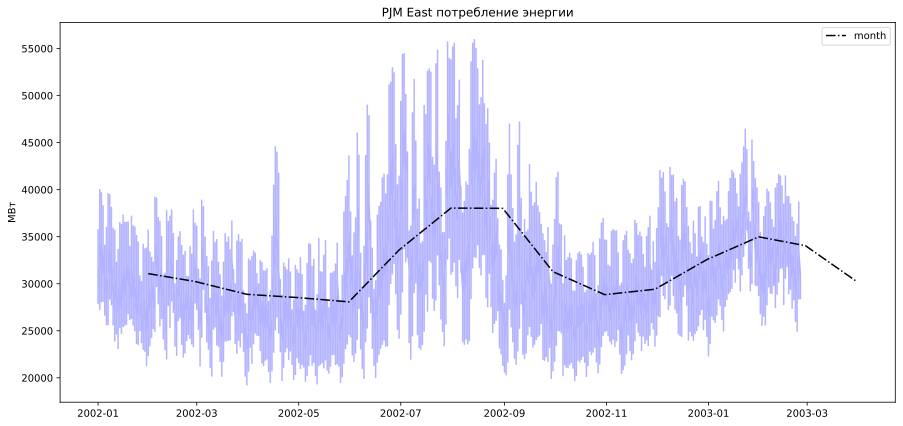

In [7]:
plt.figure(figsize =(15,7))
plt.plot(df.index[:5*24*7*4*3], df.PJME_MW.values[:5*24*7*4*3], 'b',alpha =0.3)
plt.plot(df_m.index[:5*3], df_m.PJME_MW.values[:5*3], '-.k',label='month')
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

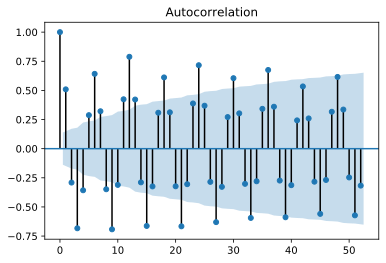

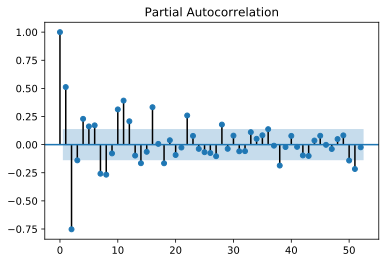

In [8]:
sm.graphics.tsa.plot_acf(df_m.PJME_MW.values, lags=52)
plt.show()
sm.graphics.tsa.plot_pacf(df_m.PJME_MW.values, lags=52)
plt.show()

In [9]:
q = 2
p = 1
d = 2
pdq = [p, d, q]

qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs, 12] 

In [10]:
model = sm.tsa.statespace.SARIMAX(df_m.PJME_MW.values[:-12], 
                                  order=pdq, 
                                  seasonal_order=seasonal_pdq,
                                  enforce_stationarity= False,
                                  enforce_invertibility=False)

In [11]:
results = model.fit()

In [12]:
print(results.summary().tables[0],results.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  188
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood               -1425.036
Date:                              Sun, 26 Jan 2020   AIC                           2860.072
Time:                                      20:46:02   BIC                           2875.416
Sample:                                           0   HQIC                          2866.303
                                              - 188                                         
Covariance Type:                                opg                                         
============================================================================================ ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

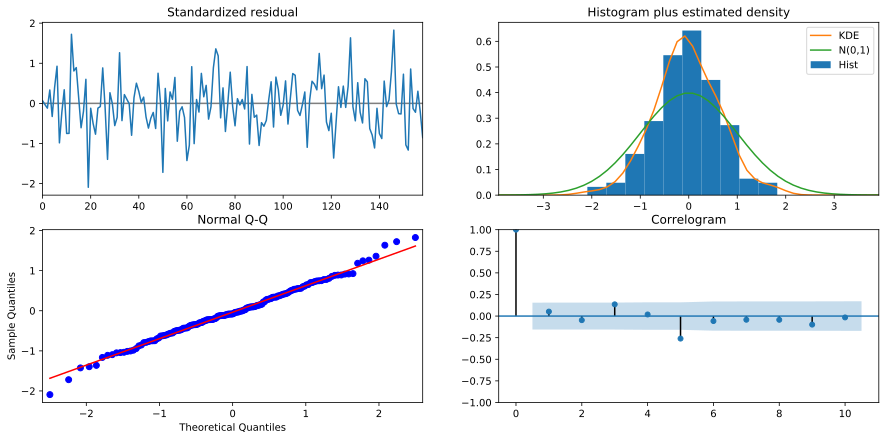

In [13]:
results.plot_diagnostics(figsize=(15, 7))
plt.show()

2. Подберите параметры модели SARIMAX для этого ряда.

In [14]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [15]:
def train_model(data, pdq, seasonal_pdq):
    warnings.filterwarnings('ignore')
    try:
        model = sm.tsa.statespace.SARIMAX(data, 
                                          order=pdq, 
                                          seasonal_order=seasonal_pdq,
                                          enforce_stationarity= False,
                                          enforce_invertibility=False)
                                    
        results = model.fit()
        return (f'ARIMA {pdq}x{seasonal_pdq}', results.aic)
    except:
            return (f'ARIMA {pdq}x{seasonal_pdq}', None)

In [16]:
def grid_search(data, pdq, seasonal_pdq, parallel=True):
    config_list = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            config_list.append((param, param_seasonal))
        
    if parallel:

        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(train_model)(data, param, param_seasonal) for param, param_seasonal in config_list)
        scores = executor(tasks)
    else:
        scores = [train_model(data, param, param_seasonal) for param, param_seasonal in config_list]
    
    scores = [score for score in scores if score[1] is not None]
    scores.sort(key=lambda tup: tup[1])
    
    return scores

In [17]:
%%time
scores = grid_search(df_m.PJME_MW.values[:-12], pdq, seasonal_pdq, parallel=True)
print(f'Best model: {scores[0][0]} - {scores[0][1]}')

Best model: ARIMA (1, 1, 1)x(1, 1, 1, 12) - 2845.8073081879766
CPU times: user 106 ms, sys: 41.2 ms, total: 147 ms
Wall time: 1.84 s


In [18]:
%%time
scores = grid_search(df_m.PJME_MW.values[:-12], pdq, seasonal_pdq, parallel=False)
print(f'Best model: {scores[0][0]} - {scores[0][1]}')

Best model: ARIMA (1, 1, 1)x(1, 1, 1, 12) - 2845.8073081879766
CPU times: user 7.69 s, sys: 4.07 ms, total: 7.69 s
Wall time: 7.7 s


In [19]:
print('Top 5 models')
for i in range(0,10):
    print(f'{scores[i][0]}: {scores[i][1]}')

Top 5 models
ARIMA (1, 1, 1)x(1, 1, 1, 12): 2845.8073081879766
ARIMA (0, 1, 1)x(1, 1, 1, 12): 2858.2316126454666
ARIMA (0, 1, 1)x(0, 1, 1, 12): 2859.5938665206118
ARIMA (1, 1, 1)x(0, 1, 1, 12): 2862.1501303766177
ARIMA (1, 0, 1)x(0, 1, 1, 12): 2880.307092774897
ARIMA (0, 0, 1)x(1, 1, 1, 12): 2881.670496503003
ARIMA (1, 0, 1)x(1, 1, 1, 12): 2881.8735555910207
ARIMA (0, 0, 1)x(0, 1, 1, 12): 2890.4757577812406
ARIMA (1, 0, 0)x(1, 1, 0, 12): 2894.867003554282
ARIMA (1, 0, 0)x(1, 1, 1, 12): 2895.1144426357732


In [20]:
order=[1,1,1]
seasonal_order=[1,1,1,12]

model = sm.tsa.statespace.SARIMAX(df_m.PJME_MW.values[:-12],order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_opt = model.fit()
print(f'AIC:{results_opt.aic}')

AIC:2845.8073081879766


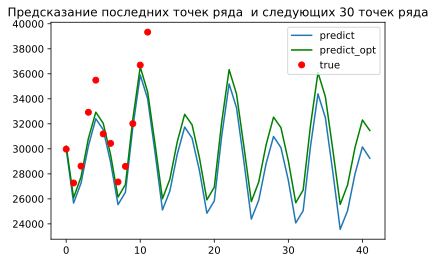

In [21]:
pred_dynamic = results.forecast(42)  
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
plt.plot(df_m.PJME_MW.values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [22]:
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-4.65188106337156, 0.00010352736844787079, 4, 183, {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}, 3038.858065386702)


3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Чем больше интервал сглаживания (ресемплинг), ниже информационный критерий Акаике. Из-за снижения влияния "шума".